# Detector efficiency

This notebook shows an example of how to perform a full bayesian analysis. The goal is to measure the efficiency of a detector and derive its full posterior distribution. On this way we will extensively discuss the role of the prior and how the results can be presented.

## Setup

The scenario we want to investigate is shown below:

![A test image](ClawsDetector.png)

We want to measure the efficiency of a sensor (device under test, DUT) detecting cosmic muons. Muons are small particles that constantly arrive at earth originating from processes in the athmosphere. In order to test wether a muon should have been measured we put two additional detectors (triggers) on top and below the DUT. If we get a signal in both the trigger detectors we know that our DUT should have also measured a signal.

In [1]:
import numpy as np

import scipy.stats as stats
from scipy.special import binom as binom_coef

import matplotlib.pyplot as plt

## Data

We count the number of trigger signals N in a certain time as well as the number of signals measured in our detector r. For this example we assume N=100 and r=98.

In [2]:
N = 100
r = 98

## Frequentist Result

In a frequentist approach we could use our measured data and arrive at the conclusion that the efficiency of the detector is e = N/r = 98%. This gives us only a point estimate. In order to derive a full posterior probability distribution of the efficiency of the detector we need a beayesian approach.

## Bayesian Approach

### Probability Model / Likelihood

As always in a bayesian analysis we need to select a model that describes the process we want to analyse, called the likelihood p(D|e). In our case, the efficiency of a detector can be modeled by a binomial model.


In [3]:
def likelihood(N,r,e):
    return stats.binom.pmf(r,N,e)

### Prior

Next we need to define a prior p(e). Here, we start with the most trivial choice, a flat prior. We will discuss the influence of a different prior choice later.

In [4]:
def flatPrior(e, param):
    if(e >= 0 and e <= 1): return 1
    else: return 0

### Marginal likelihood

The marginal likelihood p(D) is the denominator in bayes theorem. Luckily we can determine it numerical by normalizing the product of likelihood and prior to 1 by scanning of the parameter space of e. The argument "priorParams" is currently not necessary but will be used for more complex priors.

In [5]:
def marginalLikelihood(N,r, prior, priorParams):
    normFactor = 0.
    steps = 1000.
    for k in range(1,int(steps)):
        e = k/steps
        normFactor+= likelihood(N,r,e) * prior(e, priorParams) / steps
    return normFactor

### Posterior

With this we can now calculate the posterior.

In [6]:
def calculatePosterior(N,r, prior, priorParams):
    steps = 1000
    norm = marginalLikelihood(N,r, prior, priorParams)
    x_values = np.linspace(0,1,steps)
    posterior_values = [likelihood(N,r,e) * prior(e, priorParams) / norm for e in x_values]
    
    return np.asarray(x_values), np.asarray(posterior_values)

In [7]:
x_values, posterior_flatPrior = calculatePosterior(N,r, flatPrior, [])

Let us plot the results

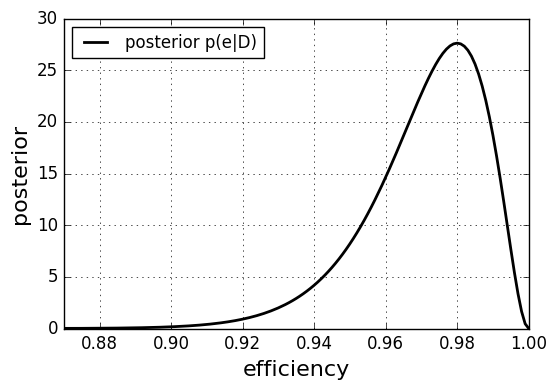

In [8]:
plt.ylim(0,30)
plt.xlim(0.87,1)
plt.xlabel('efficiency', fontsize=16)
plt.ylabel('posterior', fontsize=16)
plt.plot(x_values, posterior_flatPrior, color='black', label='posterior p(e|D)', lw=2, linestyle='-')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig("std_posterior.png")
plt.show()

You can see that the most probable result is e=98% which is the same as the intuitive frequentist result. But we got much more information here. We got the full posterior probability distribution. For example we can see that the distribution is asymetric. An efficiency of 97% has a higher probability than an efficiency of 99%. And to both probabilities we can assign exact numbers. How did we get this extra information? It is because we were putting in more information. We assumed that the behaviour of the detector follows a binomial distribution as well as we assumed a flat prior distribution.

## Influence of the prior

Next we will see what happens if we change the prior. Let's say, we find in the data sheet of the sensors a statement that the efficiency of the sensors can be assumed to be gaussian distributed around 98% with a standard deviation of s=1%. In an older version of the data sheet, however, we find that the efficiency of the sensors should be gaussian distributed around 92% with the same standard deviation of s=1%. We incorporate this information into the posterior by changing the priors accordingly.

In [9]:
def gausPrior(p, param):
    if(len(param) != 2):
        print("Wrong number of parameters for prior. We need 2, %d given." % len(param))
        return 0
    mean = param[0]
    std = param[1]
    return stats.norm.pdf(p,loc=mean,scale=std)

In [10]:
N = 100
r = 98

x_values, posterior_gausPriorPA = calculatePosterior(N,r, gausPrior, [0.98,0.01])
x_values, posterior_gausPriorP = calculatePosterior(N,r, gausPrior, [0.92,0.01])

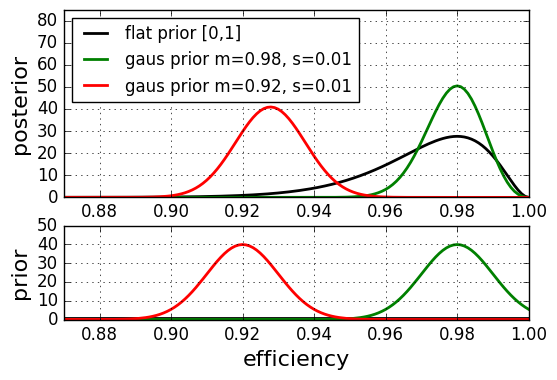

In [11]:
fig, (a0, a1) = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]})

a0.plot(x_values, posterior_flatPrior, color='black', label='flat prior [0,1]', lw=2, linestyle='-')
a0.plot(x_values, posterior_gausPriorPA, color='green', label='gaus prior m=0.98, s=0.01', lw=2)
a0.plot(x_values, posterior_gausPriorP, color = 'red', label='gaus prior m=0.92, s=0.01', lw=2, linestyle='-')
a0.set_ylim(0,85)
a0.set_xlim(0.87,1)
a0.set_xlabel('efficiency', fontsize=16)
a0.set_ylabel('posterior', fontsize=16)

a0.tick_params(axis='both', which='major', labelsize=12)
a0.tick_params(axis='both', which='minor', labelsize=8)
a0.grid(True)
a0.legend(loc='upper left')


flatPrior_values = [flatPrior(p, []) for p in x_values]
gausGood_values = [gausPrior(p, [0.98,0.01]) for p in x_values]
gausBad_values = [gausPrior(p, [0.92,0.01]) for p in x_values]


a1.plot(x_values, flatPrior_values, color='black', label='flat prior [0,1]', lw=2)
a1.plot(x_values, gausGood_values, color='green', label='flat prior [0.95,1.0]', lw=2)
a1.plot(x_values, gausBad_values, color='red', label='flat prior [0.0,0.92]', lw=2)

a1.set_ylim(0,50)
a1.set_xlim(0.87,1)
a1.set_xlabel('efficiency', fontsize=16)
a1.set_ylabel('prior', fontsize=16)

a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=8)
a1.grid(True)
#plt.legend(loc='upper left')
plt.savefig("gaussianPriors.png")
plt.show()

Here, the posterior is shown on top and the corresponding priors in the panel below. The black curve shows the previous result with the flat prior. Changing the prior to a gaussian one with mean m=98% (green) the posterior peaks again at 98% and the confidence in our estimates are stronger compared to the flat prior case. In the case, the prior supports our data. While an efficiency below 95% still had a reasonable probability in the case of the flat prior, it is nearly excluded now. Taking the prior from the old data sheet that peaked at an efficiency of 92%, we can see, that the posterior differs significantly now from the other two. The most probable value is around 93% now, competely changing our results. How can this be? The problem is that by choosing a wrong prior the data and the prior are not consistent with each other. This example shows, that choosing a wrong prior may have cathastrophic consequences. It is important to always evaluate the consistency between the priors, the probability model and the posterior.

## Incorporate a previous measurement

Another usecase for a prior is a previous measurement. Imagine your collegue measured the same sensors afterwards. He measured N2=300 and r2=280. As we had already data for such a measurement we can use our data as a prior. For this we plug the data (N1=100, r1=98) into our binomial model and use this as a prior. The results are shown below.

In [12]:
def previousMeasurementPrior(p, param):
    if(len(param) != 2):
        print("Wrong number of parameters for prior. We need 2, %d given." % len(param))
        return 0
    N = param[0]
    r = param[1]
    return stats.binom.pmf(r,N,p)*(N+1)

In [13]:
N = 300
r = 280
x_values, posterior_previousMeasurement = calculatePosterior(N,r, previousMeasurementPrior, [100,98])
x_values, posterior_secondMeasurement_flatPrior = calculatePosterior(N,r, flatPrior, [])

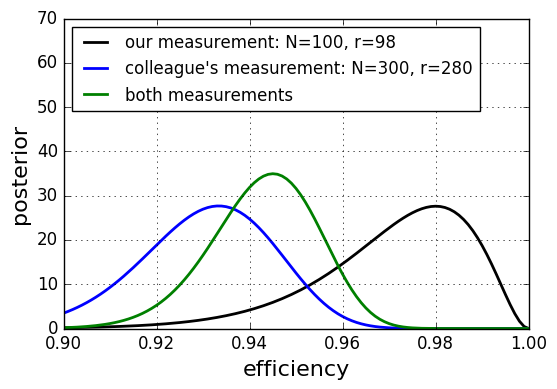

In [14]:
plt.ylim(0,70)
plt.xlim(0.90,1)
plt.xlabel('efficiency', fontsize=16)
plt.ylabel('posterior', fontsize=16)
plt.plot(x_values, posterior_flatPrior, color='black', label='our measurement: N=100, r=98', lw=2)
plt.plot(x_values, posterior_secondMeasurement_flatPrior, color='blue', label='colleague\'s measurement: N=300, r=280', lw=2)
plt.plot(x_values, posterior_previousMeasurement, color='green', label='both measurements', lw=2)


plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig("previousMeasurement.png")

plt.show()

You can see the posterior distribution of our measurement (black) and the collegues measurement (blue) both using flat priors. If we use our measurement as a prior for our collegues analysis, we arrive at the green curve. The most probable value of the green curve is in between the other two curves, but more shifted to the blue curve as our collegues measurement has more data. Side note: You will arrive at the same posterior if you redo the analysis and assume only one measurement with N=N1+N2=400 and r=r1+r2=378. This can be easily verified by hand

![Derivation](derivation.png)

## How to present your results

After calculating the posterior and analyzing the influence of the prior, we now want to present our results. Ideally, you want to show the full posterior distribution, as this reflects the full information. However, this is not always possible and you may want to summarize it with a set of values. Often you want to give a point estimate along with an interval that summarizes the width of the distribution. Often used choices include:

- Expectation value & standard deviation
- Median & central interval
- Mode & smalles interval

For a normal distribution, all three choices lead to the same results. However, in our case of a skewed distribution, we get quite different results.

In [15]:
def calculateExpectationValue(x,posterior):
    return np.sum(np.multiply(x, posterior)) / len(x)

In [16]:
def calculateMode(x,posterior):
    l = list(sorted(zip(posterior, x), reverse=True))
    return l[0][1]

In [17]:
def calculateMedian(x,posterior):
    s = 0.
    for e in zip(x, posterior):
        s += e[1] / len(x)
        if(s >= 0.5):
            return e[0]

Expectation value: 0.969617629268
Mode: 0.97997997998
Median: 0.973973973974


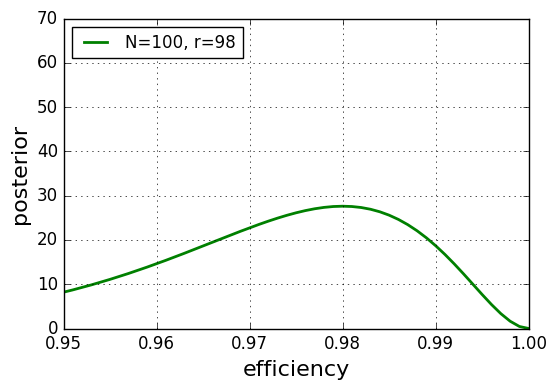

In [18]:
N = 100
r = 98
x_values, posterior_values_skewed = calculatePosterior(N,r, flatPrior, [])

expectation_value = calculateExpectationValue(x_values, posterior_values_skewed)
print("Expectation value:", expectation_value)

mode = calculateMode(x_values, posterior_values_skewed)
print("Mode:", mode)

median = calculateMedian(x_values, posterior_values_skewed)
print("Median:", median)


plt.ylim(0,70)
plt.xlim(0.95,1)
plt.xlabel('efficiency', fontsize=16)
plt.ylabel('posterior', fontsize=16)
#plt.plot(x_values, posterior_values_flatPrior, color='black', label='first measurement: N=100, r=98', lw=2)
#plt.plot(x_values, posterior_values_secondMeasurement_flatPrior, color='blue', label='second measurement: N=300, r=289', lw=2)
plt.plot(x_values, posterior_values_skewed, color='green', label='N=100, r=98', lw=2)
#plt.plot(expectation_value, 30, marker='v', markersize='10', linestyle='', color='yellow')
#plt.plot(mode, 40, marker='v', markersize='10', linestyle='', color='red')
#plt.plot(median, 35,  marker='v', markersize='10', linestyle='', color='orange')


plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [19]:
stdev = np.sqrt(np.sum((pow(x_values,2)*posterior_values_skewed)/len(x_values)) - pow(np.sum((x_values*posterior_values_skewed)/len(x_values)),2))

In [20]:
stdev

0.034899511434875546

In [21]:
def smallest_interval(mode, x_values, posterior_values, alpha, stepsize):
    l = list(sorted(zip(posterior_values, x_values), reverse=True))
    count = 0.
    i = 0
    x_min = x_max = 0
    p = mode # mode
    while count < (1-alpha):
        count+= l[i][0]*stepsize
        if(l[i][1] >= p):
            x_max = l[i][1]
        else:
            x_min = l[i][1]
        i=i+1
    return x_min, x_max, count

In [22]:
def central_interval(posterior_values, alpha):
    x_min = 0
    s = posterior_values[0]/len(posterior_values)
    while s <= alpha/2:
        x_min += 1
        s += posterior_values[x_min]/len(posterior_values)

    x_max = len(posterior_values)-1
    s = posterior_values[x_max]
    while s <= alpha/2:
        x_max -= 1
        s += posterior_values[x_max]/len(posterior_values)
  
    return x_min, x_max
    

In [23]:
si_values = smallest_interval(mode, x_values, posterior_values_skewed, 0.32, 0.001)
si_min = si_values[0]
si_max = si_values[1]
print("The smallest interval ist between %f and %f, containing %f of the probability" % (si_values[0], si_values[1], si_values[2]))

The smallest interval ist between 0.961962 and 0.990991, containing 0.695290 of the probability


In [24]:
ci_min, ci_max = central_interval(posterior_values_skewed, 0.32)
ci_indices = np.arange(ci_min, ci_max,1)

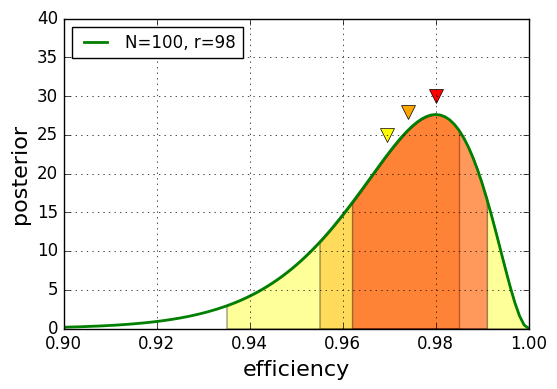

In [25]:
plt.ylim(0,40)
plt.xlim(0.90,1.0)
plt.xlabel('efficiency', fontsize=16)
plt.ylabel('posterior', fontsize=16)

plt.plot(x_values, posterior_values_skewed, color='green', label='N=100, r=98', lw=2)

plt.plot(expectation_value,25, marker='v', markersize='10', linestyle='', color='yellow')
plt.plot(median, 28,  marker='v', markersize='10', linestyle='', color='orange')
plt.plot(mode, 30, marker='v', markersize='10', linestyle='', color='red')

stdev_interval = np.arange(expectation_value-stdev, expectation_value+stdev,0.001)
stdev_indices = (stdev_interval*1000).astype(int)
stdev_indices = stdev_indices[stdev_indices<1000]

si_interval = np.arange(si_min, si_max,0.001)
si_indices = (si_interval*1000).astype(int)
si_indices = si_indices[si_indices<1000]

plt.fill_between(np.add(stdev_indices,1)/1000, posterior_values_skewed[stdev_indices], facecolor='yellow', alpha=0.4)
plt.fill_between(np.add(ci_indices,1)/1000, posterior_values_skewed[ci_indices], facecolor='orange', alpha=0.4)
plt.fill_between(np.add(si_indices,1)/1000, posterior_values_skewed[si_indices], facecolor='red', alpha=0.4)


plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig("results.png")
plt.show()

You can see that all three choices lead to different results. None of these is wrong or correct, it is just important to report exactly what point estimates you used and how you constructed your intervals.